# Snowpark - Classification Heart Patient Data

This notebook needs to be implemented ahead in order to use the <b>Streamlit App</b>. It will create the Stored Procedures needed by the App so all training and inference is implemented at Snowflake side.

The notebook will also test the functions for training and inference locally at this notebook before running it with Snowflake.

Datasets has been obtained from: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

Carlos Carrero - March 2023

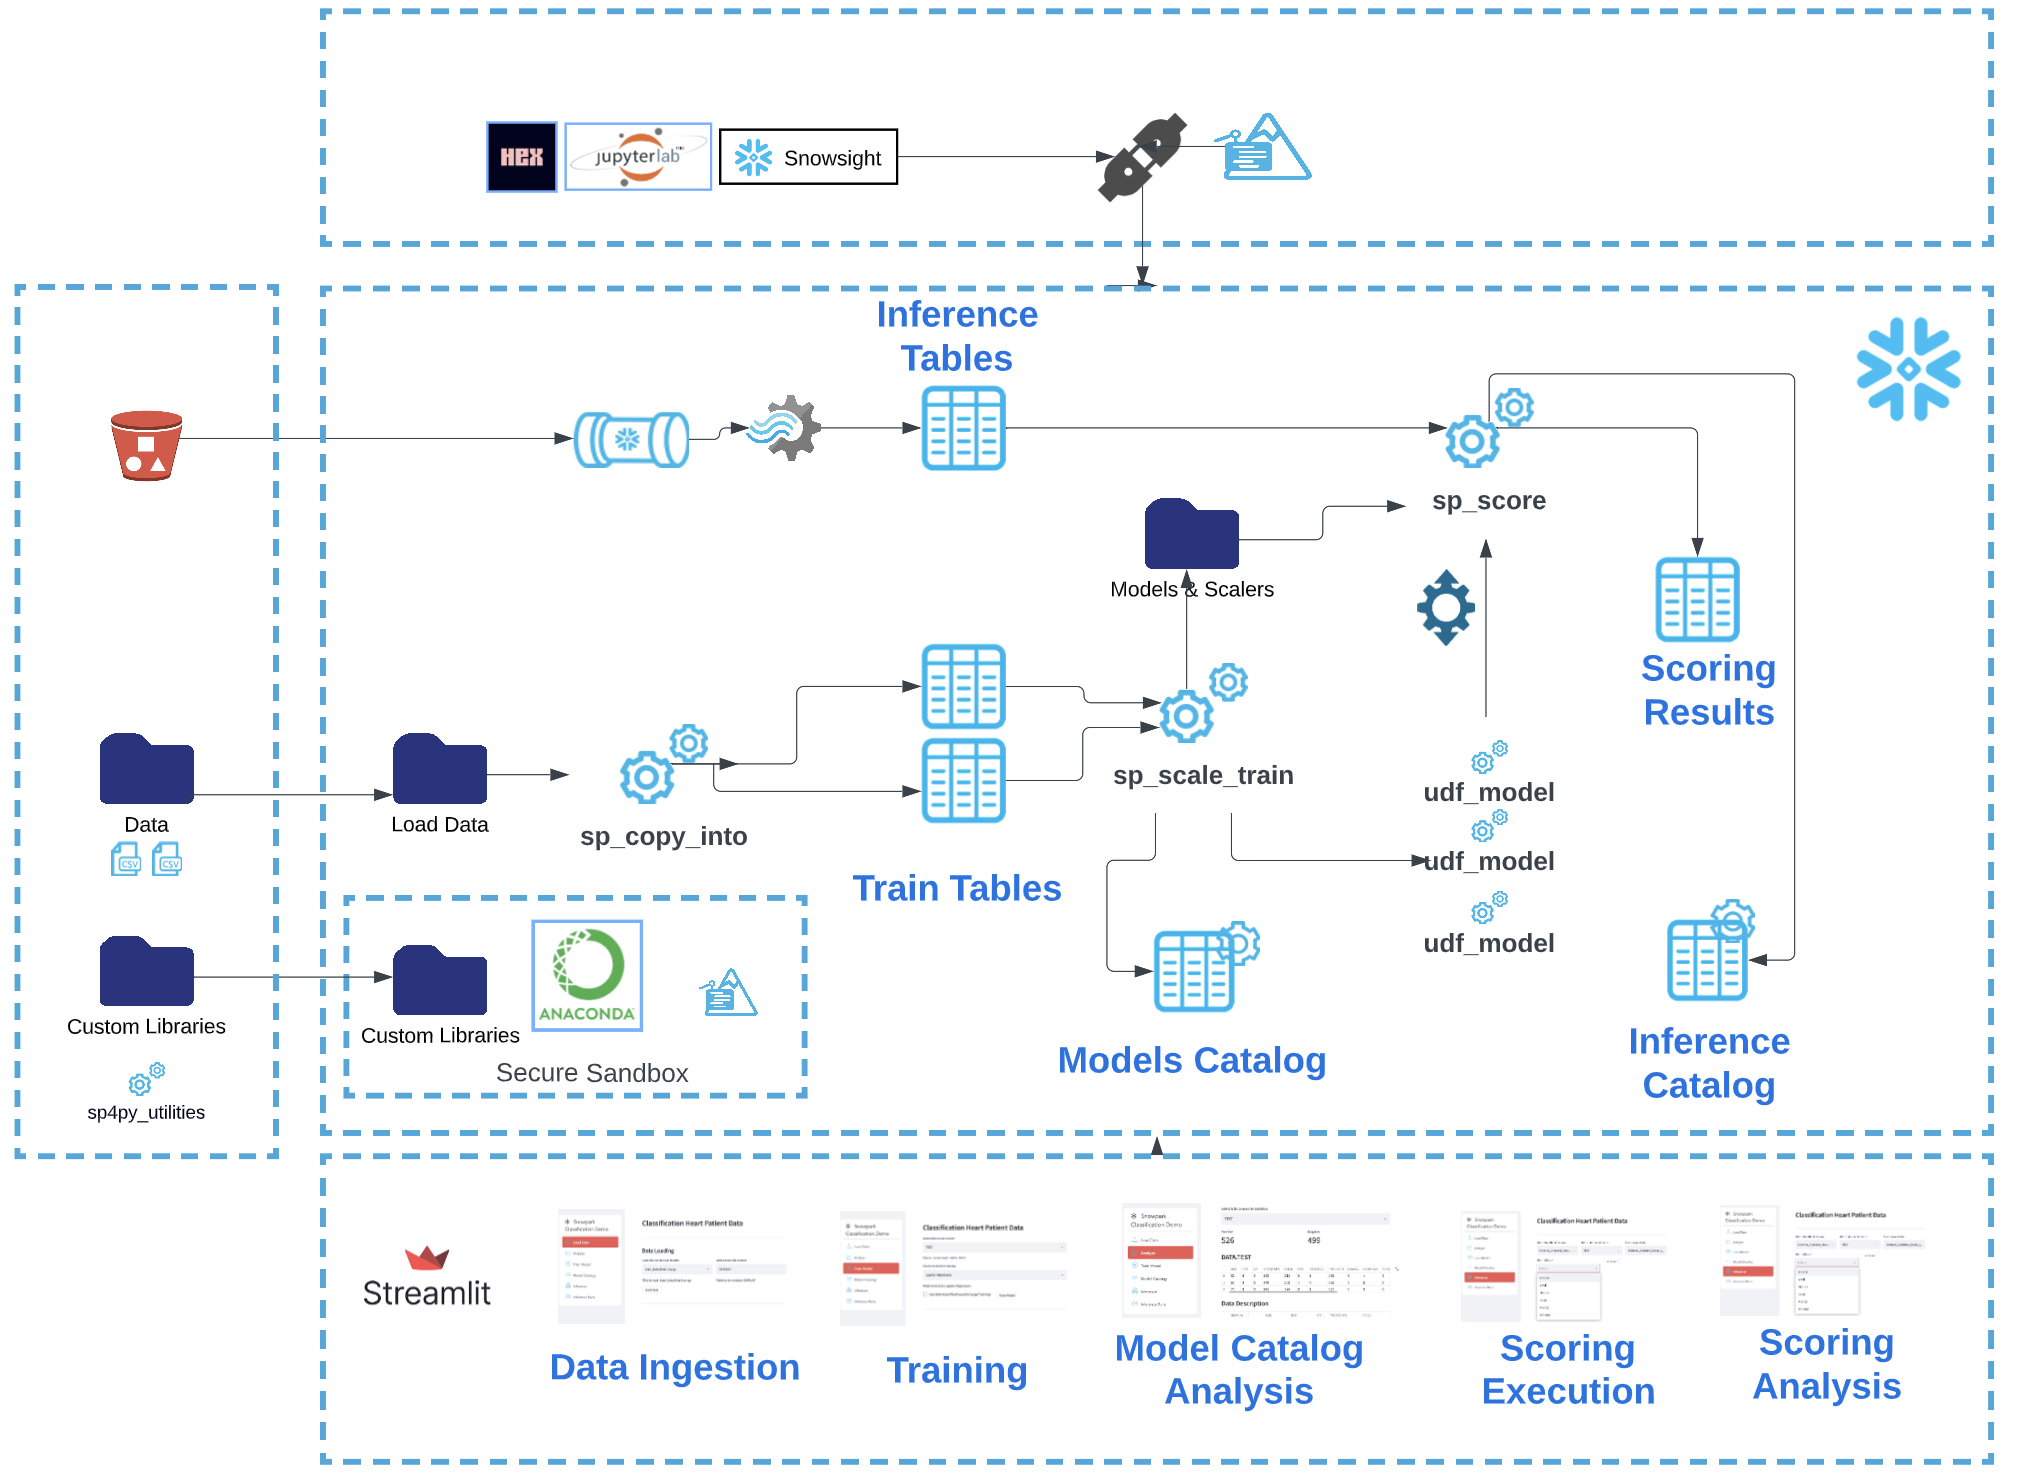

In [1]:
from IPython.display import Image, display
display(Image(filename='images/diagram.png', embed=True))

# Infrastructure Setup

This section will create the infrastructure needed to run the Streamlit App. It will create a database, a virtual warehouse and staging areas. Some key concepts in case you are new to Snowflake:

- <b>Virtual warehouse</b>: At Snowflake, storage is completely isolated from compute. Compute is run within a virutal warehosue, that can have from 1 to 512 nodes. Provision is instantaneous and you can also resize the number of nodes inmediately. warehouse usage is billed by seconds with a minimum of one minute. Warehouses are also isolated from other warehouses, what means you can run any heavy ML training or inference at the same time your BI users are running busy reports and data is being ingested. Also, no more waiting for minutes for your clusters to be ready, as warehouses are provisioned in one second.
- <b>Stored Procedure</b>: Function to be executed within Snowflake. It can be Python, Java, Scala or SQL. It can get access to the Secure Ananconda Repository with curated Python packages or you can upload your own libraries
- <b>User Defined Functions</b>: Used with ML to provide inference because its scalability. You can write UDFs in the language of your choice like SPs. It can be called within a SQL sentence or a Snowflake Dataframe transformation. There are scalar (UDF) and tabluar (UDTF) functions. The Snowflake vectorized engine will spread their execution across all availability nodes within a virtual warehouse
- <b>Staging Area</b>: File storeage location where we will be storing models. Also used to upload custom python packages and a location to push down code from a notebook like this one into Snowflake
- <b>Zero-Copy Clonning</b>: Allows to take an immediate copy of any database, schema or table. It does not use any aditional storage as it is just a meta-data operation where the new table is pointing to the same micro-partition (Snowflake table format). This can be used to keep a copy of the data that was used to train a model and it can be used just before training

First import libraries that will be used:

In [2]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

import pandas as pd
import json

Update your creds.json file with the URL of your Snowflake account, the user and password to be used. This will give us the "session" that will be used to connect and interact with Snowflake.

In [3]:
with open('creds.json') as f:
    connection_parameters = json.load(f) 

In [4]:
session = Session.builder.configs(connection_parameters).create()

#### Next cell will create or replace a database called HEART_DB. Do not execute it if you have a database with that name. Rename it as needed

In [5]:
session.sql("CREATE OR REPLACE WAREHOUSE HOL_WH WITH WAREHOUSE_SIZE='X-SMALL'").collect()
session.sql("CREATE OR REPLACE DATABASE HEART_DB").collect()
session.sql("CREATE OR REPLACE SCHEMA DATA").collect() # one scpecific schema for training and inference data
session.sql("use schema PUBLIC").collect()

[Row(status='Statement executed successfully.')]

Check your connection and database is correct:

In [6]:
session.sql('select current_warehouse(), current_database(), current_schema(), current_user(), current_role()').collect()


[Row(CURRENT_WAREHOUSE()='HOL_WH', CURRENT_DATABASE()='HEART_DB', CURRENT_SCHEMA()='PUBLIC', CURRENT_USER()='JOHN', CURRENT_ROLE()='ACCOUNTADMIN')]

## Staging Areas

Staging areas are Snowflake storage locations used to keep data. You can create as many as needed according to your needs. Here we create:

- <b>load_data</b>: in order to ingest data into Snowflake
- <b>models</b>: used to store ML models being generated
- <b>procedures</b>: used to pushdown Python code from this notebook into Snowflake
- <b>custom_packages</b>: will be used to store any library used not included in the Anaconda repository

Also a sequence will be used to generate unique names for the models being generated

In [7]:
session.sql("create or replace stage load_data").collect()
session.sql("create or replace stage models").collect()

session.sql("create or replace stage procedures").collect()
session.sql("create or replace stage custom_packages").collect()

session.sql("create or replace sequence seq_model_01 start = 1 increment = 1").collect()

[Row(status='Sequence SEQ_MODEL_01 successfully created.')]

## Custom Libraries
For Preprocessing we can use either sklearn libraries or custom Snowflake libraries. 

In this notebook we are going to use a custom library so you can see one example on how to use any python package not included within Anaconda repository. 

Preprocessing will be included as a native functionality for Snowflake in the very near future, so there will be no need to use a custom package or sklearn libraries.

We have unloaded the libraries from https://github.com/snowflakecorp/sp4py_utilities/blob/main/sp4py_utilities_demo_training_scoring.ipynb and it will be uploaded to custom_packages staging area to be used by stored procedures. 

In [8]:
#! unzip sp4py_utilities.zip

In [9]:
session.clear_imports()
session.clear_packages()
import sys
sys.path.insert(0, 'preprocessing')

import sp4py_utilities.preprocessing as pp

Put the zip file from your desktop into Snowflake

In [10]:
session.file.put('sp4py_utilities.zip', 'custom_packages')


[PutResult(source='sp4py_utilities.zip', target='sp4py_utilities.zip.gz', source_size=34691, target_size=32688, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

## Data upload into Snowflake
Also put the CSV files with data we are going to be using for training and testing into Snowflake. heart_1.csv and heart_2.csv are a subset of the heart.csv file. We can use those for testing

In [11]:
session.file.put('data/heart.csv', 'LOAD_DATA')
session.file.put('data/heart_1.csv', 'LOAD_DATA')
session.file.put('data/heart_2.csv', 'LOAD_DATA')

[PutResult(source='heart_2.csv', target='heart_2.csv.gz', source_size=8419, target_size=2016, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

## Internal Tables
As part of the infrastructure we create two internal tables where model performance and model catalog will be stored. One for storing data aboult each model generated and other for storing scoring results. 

These are normal tables, but could be converted into hybrid tables once it will be released.

In [12]:
schema_log=T.StructType([T.StructField("date", T.TimestampType()),
                     T.StructField("class_method", T.StringType()),
                     T.StructField("model_name", T.StringType()),
                     T.StructField("data_training", T.StringType()),
                     T.StructField("class_report", T.VariantType()),
                     T.StructField("TN", T.IntegerType()),
                     T.StructField("FP", T.IntegerType()),
                     T.StructField("FN", T.IntegerType()),
                     T.StructField("TP", T.IntegerType()),
                     T.StructField("roc_auc", T.FloatType()),
                     T.StructField("avg_precision", T.FloatType()),
                         
])

log_df = session.create_dataframe([],schema=schema_log)
log_df.write.mode('overwrite').save_as_table('Models_Catalog')

schema_inference=T.StructType([T.StructField("date", T.TimestampType()),
                     T.StructField("model_name", T.StringType()),
                     T.StructField("source_table", T.StringType()),
                     T.StructField("target_table", T.StringType()),
                     T.StructField("accuracy", T.FloatType()),
                     T.StructField("precision", T.FloatType()),
                     T.StructField("recall", T.FloatType()),
                     T.StructField("f1_score", T.FloatType()),
                     T.StructField("TN", T.IntegerType()),
                     T.StructField("FP", T.IntegerType()),
                     T.StructField("FN", T.IntegerType()),
                     T.StructField("TP", T.IntegerType()),
                     T.StructField("Time_Total", T.FloatType()),
                     T.StructField("Time_Scoring", T.FloatType())
])

inference_df = session.create_dataframe([],schema=schema_inference)
inference_df.write.mode('overwrite').save_as_table('Inference_Runs')

These are views that will be used by the Streamlit App:

In [13]:
session.sql("create or replace view accuracy_sum_v as select DATE, model_name, class_method, data_training,\
        class_report:accuracy as accuracy, roc_auc, avg_precision from MODELS_CATALOG;").collect()


cmd = """create or replace view class_report_sumary_v as\
            select model_name,  data_training,\
            class_report:"0"."f1-score" neg_f1_score,\
            class_report:"0"."precision" neg_precision,\
            class_report:"0"."recall" neg_recall,\
            class_report:"1"."f1-score" pos_f1_score,\
            class_report:"1"."precision" pos_precision,\
            class_report:"1"."recall" pos_recall,\
            class_report:"accuracy" accuracy,\
            TN, FP, FN, TP  from models_catalog"""
session.sql(cmd).collect()

session.sql("create or replace view data_training_v as select model_name, data_training from MODELS_CATALOG").collect()


[Row(status='View DATA_TRAINING_V successfully created.')]

Create a table with the models available. The Streamlit App will be querying this table to offer the models available:

In [14]:
schema_model = T.StructType([T.StructField("model_name", T.StringType())])

df_models_table = session.create_dataframe([
                         ['Optuna'],
                         ['Logistic Regression'],
                         ['Naive Bayes'], 
                         ['Random Forest Classifier'], 
                         ['DecisionTreeClassifier'],
                         ['Support Vector Classifier'],
                         ['XGBoost'],
                         ['K_NeighborsClassifier']], schema=schema_model)

df_models_table.write.mode("overwrite").save_as_table("MODELS")

## Helper Functions

Define some functions that will be used by the Streamlit App. <b>copy_into()</b> will be a Stored Procedure executed within Snowflake that will copy CSV data from the staging area into a Snowflake table. Parameters will be passed from the App

In [15]:
def copy_into (session: Session, file_name: str, table_name: str) -> str:
    
    import snowflake.snowpark.types as T

    schema_heart2=T.StructType([T.StructField("age", T.IntegerType()),
                     T.StructField("sex", T.IntegerType()),
                     T.StructField("cp", T.IntegerType()),
                     T.StructField("trestbps", T.DecimalType()),
                     T.StructField("chol", T.IntegerType()),
                     T.StructField("fbs", T.DecimalType()),
                     T.StructField("restecg", T.DecimalType()),
                     T.StructField("thalach", T.DecimalType()),
                     T.StructField("exang", T.DecimalType()),
                     T.StructField("oldpeak", T.DecimalType()),
                     T.StructField("slope", T.DecimalType()),
                     T.StructField("ca", T.DecimalType()),
                     T.StructField("thal", T.IntegerType()),
                     T.StructField("target", T.IntegerType())
    ])

    # Load the table within the DATA schema

    load_df2 = session.read\
        .option("FIELD_DELIMITER", ',')\
        .option("SKIP_HEADER", 1)\
        .option("ON_ERROR", "CONTINUE")\
        .schema(schema_heart2).csv(file_name)\
        .copy_into_table(table_name)

    return load_df2

Test the function is working correctly from the notebook

In [16]:
copy_into(session, "@LOAD_DATA/heart_1.csv", "TEST_TABLE")

[Row(file='load_data/heart_1.csv.gz', status='LOADED', rows_parsed=799, rows_loaded=799, error_limit=799, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]

Verify table has been created

In [17]:
test_df = session.table("TEST_TABLE")
test_df.limit(2).to_pandas()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,TARGET
0,52,1,0,125,212,0,1,168,0,1,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3,0,0,3,0


Now we want to register the function within Snowflake so it can be executed as a Stored Procedure. They register function will serialize the function and will push it down to Snowflake via (in this case) the @procedures staging area. From now on, this will be a permanent function, and each time it is called, a Python Secure Sandbox will automatically load it (together with any dependency) and will execute it.

This is represented on the right side of this diagram:

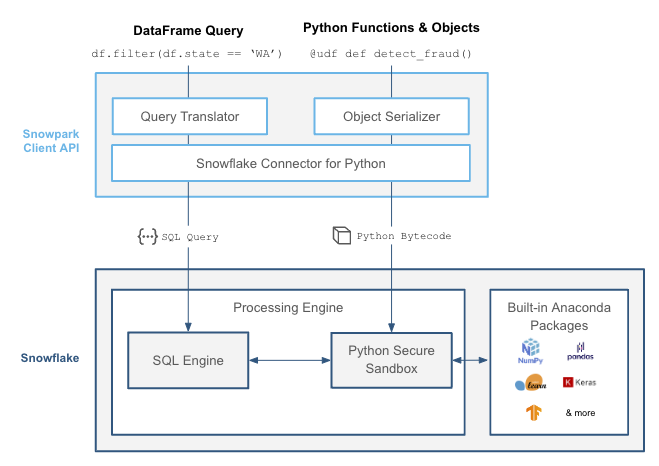

In [18]:
display(Image(filename='images/snowpark.png', embed=True))

In [19]:
session.use_warehouse("HOL_WH")

session.sproc.register(
    func=copy_into,
    name="copy_into",
    packages=['snowflake-snowpark-python'],
    is_permanent=True,
    stage_location="@procedures",
    replace=True)

Now call the Stored Procedure that will be executed within Snowflake

In [20]:
print (session.call("copy_into", "@LOAD_DATA/heart_1.csv", "TEST_TABLE2"))

[Row(file='load_data/heart_1.csv.gz', status='LOADED', rows_parsed=799, rows_loaded=799, error_limit=799, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]


Test again the table has been loaded, this time executed from Snowflake

In [21]:
test_df = session.table("TEST_TABLE2")
test_df.limit(2).to_pandas()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,TARGET
0,52,1,0,125,212,0,1,168,0,1,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3,0,0,3,0


Function to store files within a staging area (Snowflake storage location). This will be used to store ML models once trained and also save the scalers when using them for preprocessing. Snowflake also allows bringing your own models and use them to create UDFs. In this notebook, this function will be called by the training process to store the model generated in the Models staging area

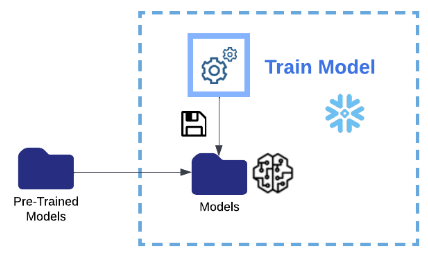

In [22]:
display(Image(filename='images/models.png', embed=True))

In [23]:
import io
import joblib
import os 

# Helper function used to save a object to a Snowflake stage, used within the training Stored procedure
def save_file_to_stage(session, obj, stage, name):
    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, name)
    joblib.dump(obj, model_file)
    session.file.put(model_file, stage,overwrite=True, auto_compress = False )


In order to run inference, a UDF is going to be created for each of the models trainined. UDF will allow us to scale as much as needed just using larger warehouses that can be resized in no time. This function will be called after training passing model trained:

In [24]:
# Function to deploy a trained model as a UDF, used by the training stored procedure
def create_udf(snf_session, udf_name, model, input_cols, stage_loc, py_packages):
    @F.udf(name=udf_name, is_permanent=True, stage_location=stage_loc, max_batch_size=1000, 
           packages=py_packages, replace=True, session=snf_session)
    def predict(ds: T.PandasSeries[dict]) -> T.PandasSeries[float]:
        df = pd.io.json.json_normalize(ds)[input_cols]
        prediction = model.predict(df)
        return prediction
    

Two functions used to log training and scoring information:
- <b>log_training()</b> will be used to store each training execution and their results
- <b>log_inference_snp()</b> will be used to log inference performed and their results

In [25]:
def log_training(session, class_method, model_name, clone_table_name, class_report, TN, FP, FN, TP,
                     auc, ave_precision):
    import datetime
    import json

    dt = datetime.datetime.now()
    dt_str = str(dt)

    cmd = "INSERT INTO MODELS_CATALOG (select '%s', '%s', '%s', '%s', PARSE_JSON('%s'),\
                        '%s','%s','%s','%s','%s','%s')" %\
        (dt_str, class_method, model_name, clone_table_name, json.dumps(class_report),\
         TN, FP, FN, TP, auc, ave_precision)
    
    session.sql(cmd).collect()

def log_inference_snp(model_name, source_table, target_table, metrics_df, time_total, time_inference):

    lg_df = metrics_df.with_columns(["date", "model_name", "source_table", "target_table", "Time_Total", "Time_Scoring"]
                                    , [F.current_timestamp(), F.lit(model_name), F.lit(source_table), F.lit(target_table), F.lit(time_total), F.lit(time_inference)])
      
    lg_df.write.save_as_table("INFERENCE_RUNS", mode="append", column_order="name")


# Models Training


This section will cover the functions used to perform training. These functions will be callec but Streamlit App but we will use this notebook to test it is working correctly

In [26]:

def sf_train(session: Session, class_method: str, table_name: str,
         stage: str, model_name: str, keep_data_clone: bool) -> dict:

    # Preprocessor from custom libraries
    import sp4py_utilities.preprocessing as pp 

    # List of all the libraries that will be offered by the Streamlit App
    import optuna
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import cross_val_score

    # Helpers
    from sklearn.metrics import (confusion_matrix, accuracy_score, 
        classification_report, 
        roc_auc_score, 
        average_precision_score, 
        precision_recall_curve, 
        roc_curve
    )
        
    from sklearn.model_selection import train_test_split
    from datetime import datetime
    import json    
    
    # Get a sequence from the Database in order to provide a unique name for the model generaged
    seq = str(session.sql("select seq_model_01.nextval").collect()[0][0])
    
    #This will be a unique model name
    model_name = model_name + "_" + seq

    # One of the key features from Snowflake that can be used when training models is Zero-Copy Cloning
    # This features allows to take an instant copy of any table without using any additional storage
    # This copy is taken in no time and it is just a metadata operation. Therefore we can keep a copy
    # of the data that was used to train the model. We allow Streamlit App for the user to decide if they
    # want to keep a copy. We append a sufix to the table name with CLONE and the Model Name
    # keep_data_clone is a parameter the user will decide when using the Streamlit App
    
    if (keep_data_clone == True):
        clone_table_name = table_name + "_CLONE_" + model_name
        session.sql("create TABLE %s clone %s "%(clone_table_name, table_name)).collect()
    else:
        clone_table_name = table_name 
    
    # Snowpark Dataframe with the table we are using for training. Note it will be lazy executed, so nothing
    # will happen at this point
    df_sf = session.table(clone_table_name)

    # Snowpark Dataframe with the target feature to predict and the other with just the features that will be
    # used for training (features_sf_df)
    target_sf_df = df_sf.select(F.col('target'))
    features_sf_df = df_sf.drop(F.col('thal')).drop(F.col('last')).drop(F.col('target'))
    
    ###################
    ## Preprocessing ##
    ###################
    
    # We are going to use StandardScaler as we only have numerical feature. 
    # sp4py_utilities custom package needs the columns names as inputs and the output names
    
    scaler_input_cols = features_sf_df.columns
    scaler_output_cols = ["SC_"+f for f in features_sf_df.columns]  

    ss = pp.StandardScaler(input_cols=scaler_input_cols, output_cols=scaler_output_cols)
    ss.fit(features_sf_df)

    # Save the StandardScaler object so we can use it later for inference
    scaler_name = model_name + ".scaler"
    save_file_to_stage(session, ss, stage, scaler_name)

    ss_features_sf_df = ss.transform(features_sf_df)
    ss_features_sf_df = ss_features_sf_df.select([*scaler_output_cols])

    ################
    ## Training   ##
    ################

    stage_loc = 'procedures' # Staging area used to store the UDF that we will define
    # We will add here the Python packages that the UDF will need. This will depend on the model
    # selected by the Streamlit app
    py_packages = ['pandas'] 
    
    # Until now, we have used used DataFrames. Now we convert to pandas to train the model
    # It is now when Snowpark Dataframes are executed
    target_df = target_sf_df.to_pandas()
    features_df = ss_features_sf_df.to_pandas()

    # use train_test_split to get 80% for training and 20% for testing
    x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.20, random_state=0)

    # class_method is passed by Streamlit with the classification method to be used
    # model is defined using the classification method and the packaged is added to py_packages list
    # Also adding Optuna with three methods in order to help finding the best method and hyperparameters
    # Idea here is that the Streamlit App usr can test different methods and see how good they are
    
    if class_method == "Optuna":
        
            n_trials = 500
            
            def objective(trial):
                classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest", "XGBoost"])
                if classifier_name == "LogReg":
                    logreg_c = trial.suggest_float("logreg_c", 0.8, 1, log=True)
                    classifier_obj = LogisticRegression(C=logreg_c)
                elif classifier_name == "RandomForest":
                    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
                    rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 100, log=True)
                    rf_max_samples = trial.suggest_float("rf_max_samples", 0.01, 1, log=True)
                    classifier_obj = RandomForestClassifier(
                        max_depth=rf_max_depth, n_estimators=rf_n_estimators, max_samples=rf_max_samples
                    )
                else:
                    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 5, 100, log=True)
                    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
                    xgb_subsample = trial.suggest_float("xgb_subsample", 0.01, 1, log=True)
                    classifier_obj = XGBClassifier(
                        n_estimators=xgb_n_estimators, max_depth=xgb_max_depth, subsample=xgb_subsample
                    )

                score = cross_val_score(classifier_obj, x_train, y_train, n_jobs=-1, cv=3, scoring='roc_auc')
                score = score.mean()
                trial.set_user_attr(key="best_booster", value=classifier_obj)
                return score

            # Callback to get best model
            def callback(study, trial):
                if study.best_trial.number == trial.number:
                    study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

            # Start Optimizing
            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=n_trials, callbacks=[callback])
    
            # Fit best model on data
            model=study.user_attrs["best_booster"]
            print (study.best_trial.params["classifier"])
            class_method = study.best_trial.params["classifier"] + "_" + class_method
            py_packages.append('xgboost==1.7.3')
            py_packages.append('scikit-learn==1.2.1')
   
    elif class_method == "Logistic Regression":
        model = LogisticRegression()
        py_packages.append('scikit-learn==1.2.1')
    elif class_method == "Naive Bayes":
        model = GaussianNB()
        py_packages.append('scikit-learn==1.2.1')
    elif class_method == "Random Forest Classifier":
        model = RandomForestClassifier(n_estimators=20, random_state=12, max_depth=5)
        py_packages.append('scikit-learn==1.2.1')
    elif class_method == "XGBoost":
        model = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
        py_packages.append('xgboost==1.7.3')
    elif class_method == "K_NeighborsClassifier":
        model = KNeighborsClassifier (n_neighbors=10)
        py_packages.append('scikit-learn==1.2.1')
    elif class_method == "Support Vector Classifier":
        model = SVC(kernel='rbf', C=2)
        py_packages.append('scikit-learn==1.2.1')
    elif class_method == "DecisionTreeClassifier":
        model = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=6)
        py_packages.append('scikit-learn==1.2.1')

    
    # Fit the Model using the training data
    model.fit(x_train, y_train)

        
    # Run a prediction on the test data
    y_pred = model.predict(x_test)
    
        
    #########################################################################
    ## Save Model and create User Defined Function for inference           ##
    ## This will allow us to use this model for inference with new         ##
    ## data. ML engineers can use it to include in the data pipelines      ##
    #########################################################################
    
    save_file_to_stage(session, model, stage, model_name)

    # Call the create_udf() helper, we pass the model_name, the model, the columns, staging area and the 
    # packages that will be used by the UDF
    input_cols = ss_features_sf_df.columns
    create_udf(session, model_name, model, input_cols, stage_loc, py_packages)
 
    ##################################
    ## Reporting and Saving Results ##
    ##################################

    # Create the confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]

    class_report = classification_report (y_test, y_pred, output_dict=True)
    acc_score = class_report["accuracy"] * 100
    
    fpr, tpr, t = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    p, r, c = precision_recall_curve(y_test, y_pred)
    ave_precision = average_precision_score(y_test, y_pred)
              
    # Call the helper to add into the MODELS_CATALOG table the results for the model generated
    log_training(session, class_method, model_name, clone_table_name, class_report, 
                 TN, FP, FN, TP, auc, ave_precision)

    ret_dict = {"Model": model_name,
                "Classifier": class_method,
                "conf matrix:": cnf_matrix.tolist(), 
                "accuracy score:": acc_score,
                "class_report": class_report,
                "fpr": fpr.tolist(),
                "tpr": tpr.tolist(),
                "p": p.tolist(),
                "r": r.tolist(),
                "auc": auc,
                "ave_precision": ave_precision
                   }
    
    return ret_dict
    

Test the function locally before creating a Stored Procedure within Snowflake

In [27]:
%%time 

ret = sf_train(session, class_method="XGBoost", table_name="TEST_TABLE",
         stage="@models", model_name="XGB", keep_data_clone=False)
print (ret)

/Users/ccarrero/miniconda3/envs/pysnowpark-ml-streamlit3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Model': 'XGB_1', 'Classifier': 'XGBoost', 'conf matrix:': [[69, 9], [9, 73]], 'accuracy score:': 88.75, 'class_report': {'0': {'precision': 0.8846153846153846, 'recall': 0.8846153846153846, 'f1-score': 0.8846153846153846, 'support': 78}, '1': {'precision': 0.8902439024390244, 'recall': 0.8902439024390244, 'f1-score': 0.8902439024390244, 'support': 82}, 'accuracy': 0.8875, 'macro avg': {'precision': 0.8874296435272044, 'recall': 0.8874296435272044, 'f1-score': 0.8874296435272044, 'support': 160}, 'weighted avg': {'precision': 0.8875, 'recall': 0.8875, 'f1-score': 0.8875, 'support': 160}}, 'fpr': [0.0, 0.11538461538461539, 1.0], 'tpr': [0.0, 0.8902439024390244, 1.0], 'p': [0.5125, 0.8902439024390244, 1.0], 'r': [1.0, 0.8902439024390244, 0.0], 'auc': 0.8874296435272044, 'ave_precision': 0.8487842058298632}
CPU times: user 2.29 s, sys: 753 ms, total: 3.04 s
Wall time: 16.8 s


We can check what has been logged in the the MODELS_CATALOG table

In [28]:
mc_df = session.table("MODELS_CATALOG")
mc_df.to_pandas()

,DATE,CLASS_METHOD,MODEL_NAME,DATA_TRAINING,CLASS_REPORT,TN,FP,FN,TP,ROC_AUC,AVG_PRECISION
0,2023-03-29 23:09:19.120581,XGBoost,XGB_1,TEST_TABLE,"{\n ""0"": {\n ""f1-score"": 0.884615384615384...",69,9,9,73,0.88743,0.848784


We can also visualize the results with a ROC Curve

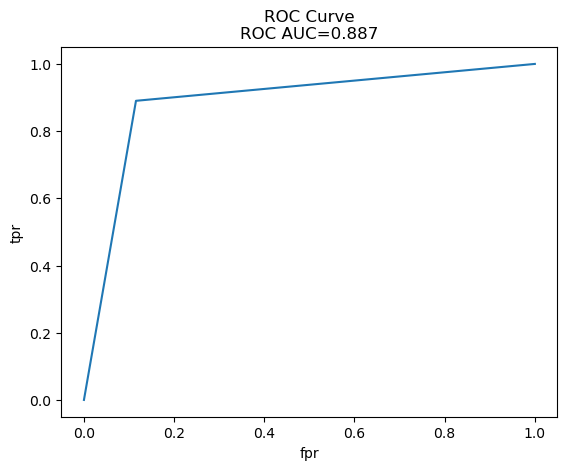

In [29]:
from matplotlib import pyplot as plt

plt.plot(ret["fpr"], ret["tpr"])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(f'ROC Curve\nROC AUC={ret["auc"]:.3f}');


And check the Precision Recall Curve

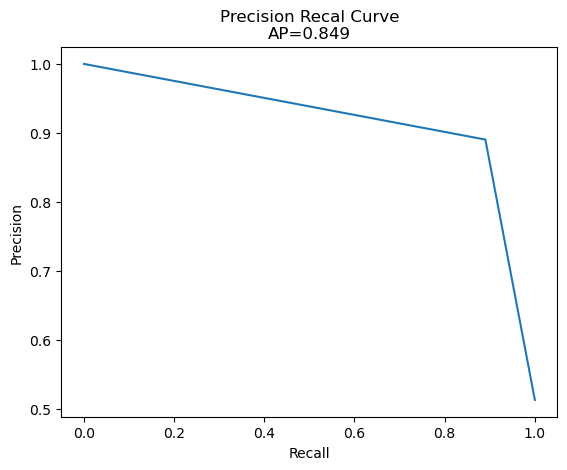

In [30]:
plt.plot(ret["r"], ret["p"])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision Recal Curve\nAP={ret["ave_precision"]:.3f}');

Check model has been created in the staging area and the UDF is ready

In [31]:
session.sql("ls @models").collect()

[Row(name='models/XGB_1', size=51184, md5='bb50ec4e020f0489e1a42a5018166dfb', last_modified='Wed, 29 Mar 2023 21:09:07 GMT'),
 Row(name='models/XGB_1.scaler', size=800, md5='3f9d5c470fc3489f3a427db5dd42e1a8', last_modified='Wed, 29 Mar 2023 21:09:06 GMT')]

Because <b>optuna</b> and <b>cmaes</b> libraries are not included in the Anaconda repository, we are going to add them from the local repository. We get the local path and we will include it later in the imports section when registering the functions as Stored Procedures

In [32]:
import optuna
optuna_path = optuna.__path__[0]
print(optuna_path)

# Get path of cmaes package
import cmaes
cmaes_path = cmaes.__path__[0]
print(cmaes_path)

/Users/ccarrero/miniconda3/envs/pysnowpark-ml-streamlit3/lib/python3.8/site-packages/optuna
/Users/ccarrero/miniconda3/envs/pysnowpark-ml-streamlit3/lib/python3.8/site-packages/cmaes


<b>Register</b> the function as a <b>Stored Procedure</b> within Snowflake
This will push down all the function and dependencies into Snowflake.
Once the SP is being defined, we can call it directly from Snowflake without the need of a notebook.
For example it can be called from a Task to trigger a new training based on new data

In [33]:
session.sproc.register(
    func=sf_train,
    name="sf_train",
    packages=['snowflake-snowpark-python',
              'scikit-learn==1.2.1',
              'joblib==1.1.1',
              'xgboost==1.7.3', 
              'sqlalchemy==1.4.39',
              'tqdm==4.64.1',
              'colorlog==5.0.1'],
    imports=['@custom_packages/sp4py_utilities.zip.gz', 
              optuna_path, 
              cmaes_path],
    is_permanent=True,
    stage_location="@procedures",
    replace=True)

Test now the Stored Procedure for training executed within Snowflake

In [34]:
session.call ("sf_train", "Random Forest Classifier", "TEST_TABLE",
         "@models", "RFC_SP", True)

'{\n  "Classifier": "Random Forest Classifier",\n  "Model": "RFC_SP_2",\n  "accuracy score:": 92.5,\n  "auc": 0.9246404002501564,\n  "ave_precision": 0.8920223577235772,\n  "class_report": {\n    "0": {\n      "f1-score": 0.922077922077922,\n      "precision": 0.9342105263157895,\n      "recall": 0.9102564102564102,\n      "support": 78\n    },\n    "1": {\n      "f1-score": 0.9277108433734941,\n      "precision": 0.9166666666666666,\n      "recall": 0.9390243902439024,\n      "support": 82\n    },\n    "accuracy": 0.925,\n    "macro avg": {\n      "f1-score": 0.9248943827257081,\n      "precision": 0.9254385964912281,\n      "recall": 0.9246404002501563,\n      "support": 160\n    },\n    "weighted avg": {\n      "f1-score": 0.9249647942419028,\n      "precision": 0.925219298245614,\n      "recall": 0.925,\n      "support": 160\n    }\n  },\n  "conf matrix:": [\n    [\n      71,\n      7\n    ],\n    [\n      5,\n      77\n    ]\n  ],\n  "fpr": [\n    0,\n    0.08974358974358974,\n   

In [35]:
session.sql("ls @models").collect()

[Row(name='models/RFC_SP_2', size=82256, md5='1c88cb7dacb67568ea2b9c395e59036c', last_modified='Wed, 29 Mar 2023 21:09:43 GMT'),
 Row(name='models/RFC_SP_2.scaler', size=800, md5='5f8e83614fbffcfaec21a486f8b8a499', last_modified='Wed, 29 Mar 2023 21:09:43 GMT'),
 Row(name='models/XGB_1', size=51184, md5='bb50ec4e020f0489e1a42a5018166dfb', last_modified='Wed, 29 Mar 2023 21:09:07 GMT'),
 Row(name='models/XGB_1.scaler', size=800, md5='3f9d5c470fc3489f3a427db5dd42e1a8', last_modified='Wed, 29 Mar 2023 21:09:06 GMT')]

# Inference

The inference function will get the table with the rows that needs to be scored and the new table where results will be saved. The function will call the UDF that has been already defined for the model choosen. The Streamlit App will list all models currently available and the user will be able to select one of them. This will be passed to the function together with the staging area for the model.

Because we are using UDFs for inference, we can get benefits of Snowflake scalability. The Streamlit App will allow users to choose the size of the Warehosue to be used. Streamlit App will resize the wharehouse used for inference instanly before running this process.

We also provide a metrics_score_snp() helper that returns a Snowpark Dataframe with the metrics scoring. Advantages of this approach instead of pure Python is that all calculatiosn are done using Snowflake vectorized engine and therefore will be able to scale accoringly.

In [36]:
# Function that calculates the metrics using Snowpark ie SQL
def metrics_score_snp(df, y_true, y_pred):
    return df.group_by([y_true, y_pred]).count()\
                .with_column("type", F.when((F.col(y_true) == 0) & (F.col(y_pred) == 0), "tn")\
                                    .when((F.col(y_true) == 0) & (F.col(y_pred) == 1), "fp")\
                                    .when((F.col(y_true) == 1) & (F.col(y_pred) == 0), "fn")\
                                    .when((F.col(y_true) == 1) & (F.col(y_pred) == 1), "tp"))\
                .select(["TYPE", "COUNT"]).pivot("TYPE", ['tn', 'tp', 'fn', 'fp']).sum("COUNT")\
                .select(F.col("'tp'").as_("tp"), F.col("'tn'").as_("tn"), F.col("'fn'").as_("fn"), F.col("'fp'").as_("fp"))\
                .with_columns(["accuracy", "precision", "recall"],
                             [((F.col("tp") + F.col("tn")) / (F.col("tp") + F.col("tn") + F.col("fn") + F.col("fp")))
                             , (F.col("tp") / (F.col("tp") + F.col("fp")))
                              ,(F.col("tp") / (F.col("tp") + F.col("fn")))])\
                .with_column("f1_score", (F.lit(2)*F.col("precision")*F.col("recall")) / (F.col("precision")+F.col("recall")))\
                .select(["ACCURACY","PRECISION", "RECALL","F1_SCORE", "TN", "FP", "FN", "TP"])
    
def sf_score(session: Session, table_name: str, table_target: str, stage: str, 
        model_name: str) -> dict:

    import joblib
    import sp4py_utilities.preprocessing as pp
    import time

    t0 = time.time()    

    # This is the Snowpark Dataframe pointing to the table with the records we have to score     
    df = session.table(table_name)
    
    #### Preprocessing ######
    ## Here we are going to use the customer StandardScaler used to train the model and that we 
    ## saved previously with the model. We load t and use it fore preprocessing before running inference
    
    df_colums = df.drop(F.col('thal')).drop(F.col('last')).drop(F.col('target'))

    file_to_get = stage + "/" + model_name + ".scaler"
    session.file.get(file_to_get, '/tmp/')

    scaler_name = "/tmp/" + model_name + ".scaler"
    scaler = joblib.load(scaler_name)

    # Perform the transformation on the original dataframe using the scaler we just loaded
    df_scaled = scaler.transform(df)
    
    ################
    ## Predicting ##
    ################
    
    ## Generate the column names we are goign to pass to the UDF
    key_vals = []
    for col in scaler.output_cols:
        key_vals.extend([F.lit(col), F.col(col)])
    
    # Taking time so we measure how much time spend predicting with UDFs
    t1 = time.time() 
    
    results_df = df_scaled.with_column("PREDICTED", F.call_udf(model_name, F.object_construct(*key_vals)))

    t2 = time.time()

    # Do not need the scaled columns for the output, so drop them
    results_df = results_df.drop(*scaler.output_cols)
    
    # get a new Snowpark Dataframe with the metrics score
    df_metrics = metrics_score_snp(results_df, y_true="TARGET", y_pred="PREDICTED")

    # Write the Snowpaark Dataframe as a table
    # NOTE: Because the lazy execution, it is at this moment when transformations and UDFs are being called
    results_df.write.mode("overwrite").save_as_table(table_target)
 
    # Get timestamps
    t3 = time.time()
    time_total = t3 - t0
    time_inference = t2 - t1

    # Write inference results into the INFERENCE_RUNS table
    log_inference_snp(model_name, table_name, table_target, df_metrics, time_total, time_inference)

    return df_metrics.collect()[0].as_dict() #accuracy, precision, recall, f1_score, TN, FP, FN, TP

Let´s test locally scoring works well. Let´s get another data into Snowflake

In [37]:
copy_into(session, "@LOAD_DATA/heart_2.csv", "TEST_TABLE2")

[Row(file='load_data/heart_2.csv.gz', status='LOADED', rows_parsed=225, rows_loaded=225, error_limit=225, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]

Check what models we have available

In [38]:
session.sql("ls @models").collect()

[Row(name='models/RFC_SP_2', size=82256, md5='1c88cb7dacb67568ea2b9c395e59036c', last_modified='Wed, 29 Mar 2023 21:09:43 GMT'),
 Row(name='models/RFC_SP_2.scaler', size=800, md5='5f8e83614fbffcfaec21a486f8b8a499', last_modified='Wed, 29 Mar 2023 21:09:43 GMT'),
 Row(name='models/XGB_1', size=51184, md5='bb50ec4e020f0489e1a42a5018166dfb', last_modified='Wed, 29 Mar 2023 21:09:07 GMT'),
 Row(name='models/XGB_1.scaler', size=800, md5='3f9d5c470fc3489f3a427db5dd42e1a8', last_modified='Wed, 29 Mar 2023 21:09:06 GMT')]

Inference on the new table using LR_1 model

In [39]:
sf_score(session, table_name="TEST_TABLE2", table_target="RESULTS_TABLE2", stage="@models", model_name="XGB_1")


{'ACCURACY': Decimal('0.885742'),
 'PRECISION': Decimal('0.865591'),
 'RECALL': Decimal('0.920000'),
 'F1_SCORE': Decimal('0.891966547770'),
 'TN': 424,
 'FP': 75,
 'FN': 42,
 'TP': 483}

Check the target table has been created with the prediction

In [40]:
df = session.table("RESULTS_TABLE2")
df.limit(2).to_pandas()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,TARGET,PREDICTED
0,61,1,0,148,203,0,1,161,0,0,2,1,3,0,0.0
1,43,0,0,132,341,1,0,136,1,3,1,0,3,0,0.0


Now register the function as one Stored Procedure within Snowflake:

In [41]:
session.sproc.register(
    func=sf_score,
    name="sf_score",
    packages=['snowflake-snowpark-python',
              'scikit-learn==1.2.1',
              'joblib==1.1.1',
              'xgboost==1.7.3'],
    imports=['@custom_packages/sp4py_utilities.zip.gz'],
    is_permanent=True,
    stage_location="@procedures",
    replace=True)

Verify the SP works well

In [42]:
session.call("sf_score", "TEST_TABLE2", "RESULTS_TABLE3", "@models", "XGB_1")


'{\n  "ACCURACY": "0.885742",\n  "F1_SCORE": "0.891966547770",\n  "FN": 42,\n  "FP": 75,\n  "PRECISION": "0.865591",\n  "RECALL": "0.920000",\n  "TN": 424,\n  "TP": 483\n}'

In [43]:
df = session.table("RESULTS_TABLE3")
df.limit(2).to_pandas()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALACH,EXANG,OLDPEAK,SLOPE,CA,THAL,TARGET,PREDICTED
0,53,1,0,140,203,1,0,155,1,3,0,0,3,0,0.0
1,54,1,0,122,286,0,0,116,1,3,1,2,2,0,0.0


Let´s check the content of the other tables that has been created

In [44]:
df = session.table("INFERENCE_RUNS")
df.to_pandas()

,DATE,MODEL_NAME,SOURCE_TABLE,TARGET_TABLE,ACCURACY,PRECISION,RECALL,F1_SCORE,TN,FP,FN,TP,TIME_TOTAL,TIME_SCORING
0,2023-03-29 14:09:59.509,XGB_1,TEST_TABLE2,RESULTS_TABLE2,0.885742,0.865591,0.92,0.891967,424,75,42,483,4.031141,0.002765
1,2023-03-29 14:10:25.897,XGB_1,TEST_TABLE2,RESULTS_TABLE3,0.885742,0.865591,0.92,0.891967,424,75,42,483,2.859271,0.002111


In [45]:
df = session.table("MODELS_CATALOG")
df.to_pandas()

,DATE,CLASS_METHOD,MODEL_NAME,DATA_TRAINING,CLASS_REPORT,TN,FP,FN,TP,ROC_AUC,AVG_PRECISION
0,2023-03-29 23:09:19.120581,XGBoost,XGB_1,TEST_TABLE,"{\n ""0"": {\n ""f1-score"": 0.884615384615384...",69,9,9,73,0.88743,0.848784
1,2023-03-29 14:09:53.352110,Random Forest Classifier,RFC_SP_2,TEST_TABLE_CLONE_RFC_SP_2,"{\n ""0"": {\n ""f1-score"": 0.922077922077922...",71,7,5,77,0.92464,0.892022


## Next Steps

Now that you have run this notebook and hopefully all infrastructure has been created, execute the Streamlit App to keep testing hwo different models works and how inference can be run on tables.

Once you have executed all this setup, this should be the content of your database if you login into Snowflake:

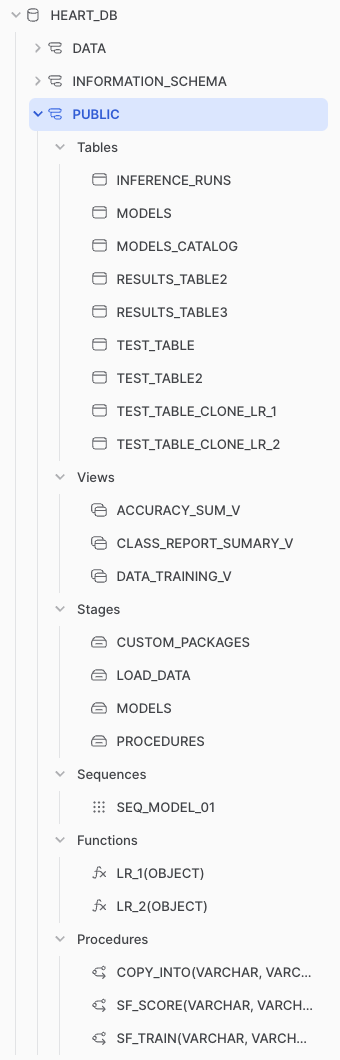

In [46]:
display(Image(filename='images/DB.png', embed=True))

Now run the streamlit App. From a Terminal:

conda activate pysnowpark-ml-streamlit

streamlit run app_heart.py

Start loading some data, running some training and making some inference so you can see different results


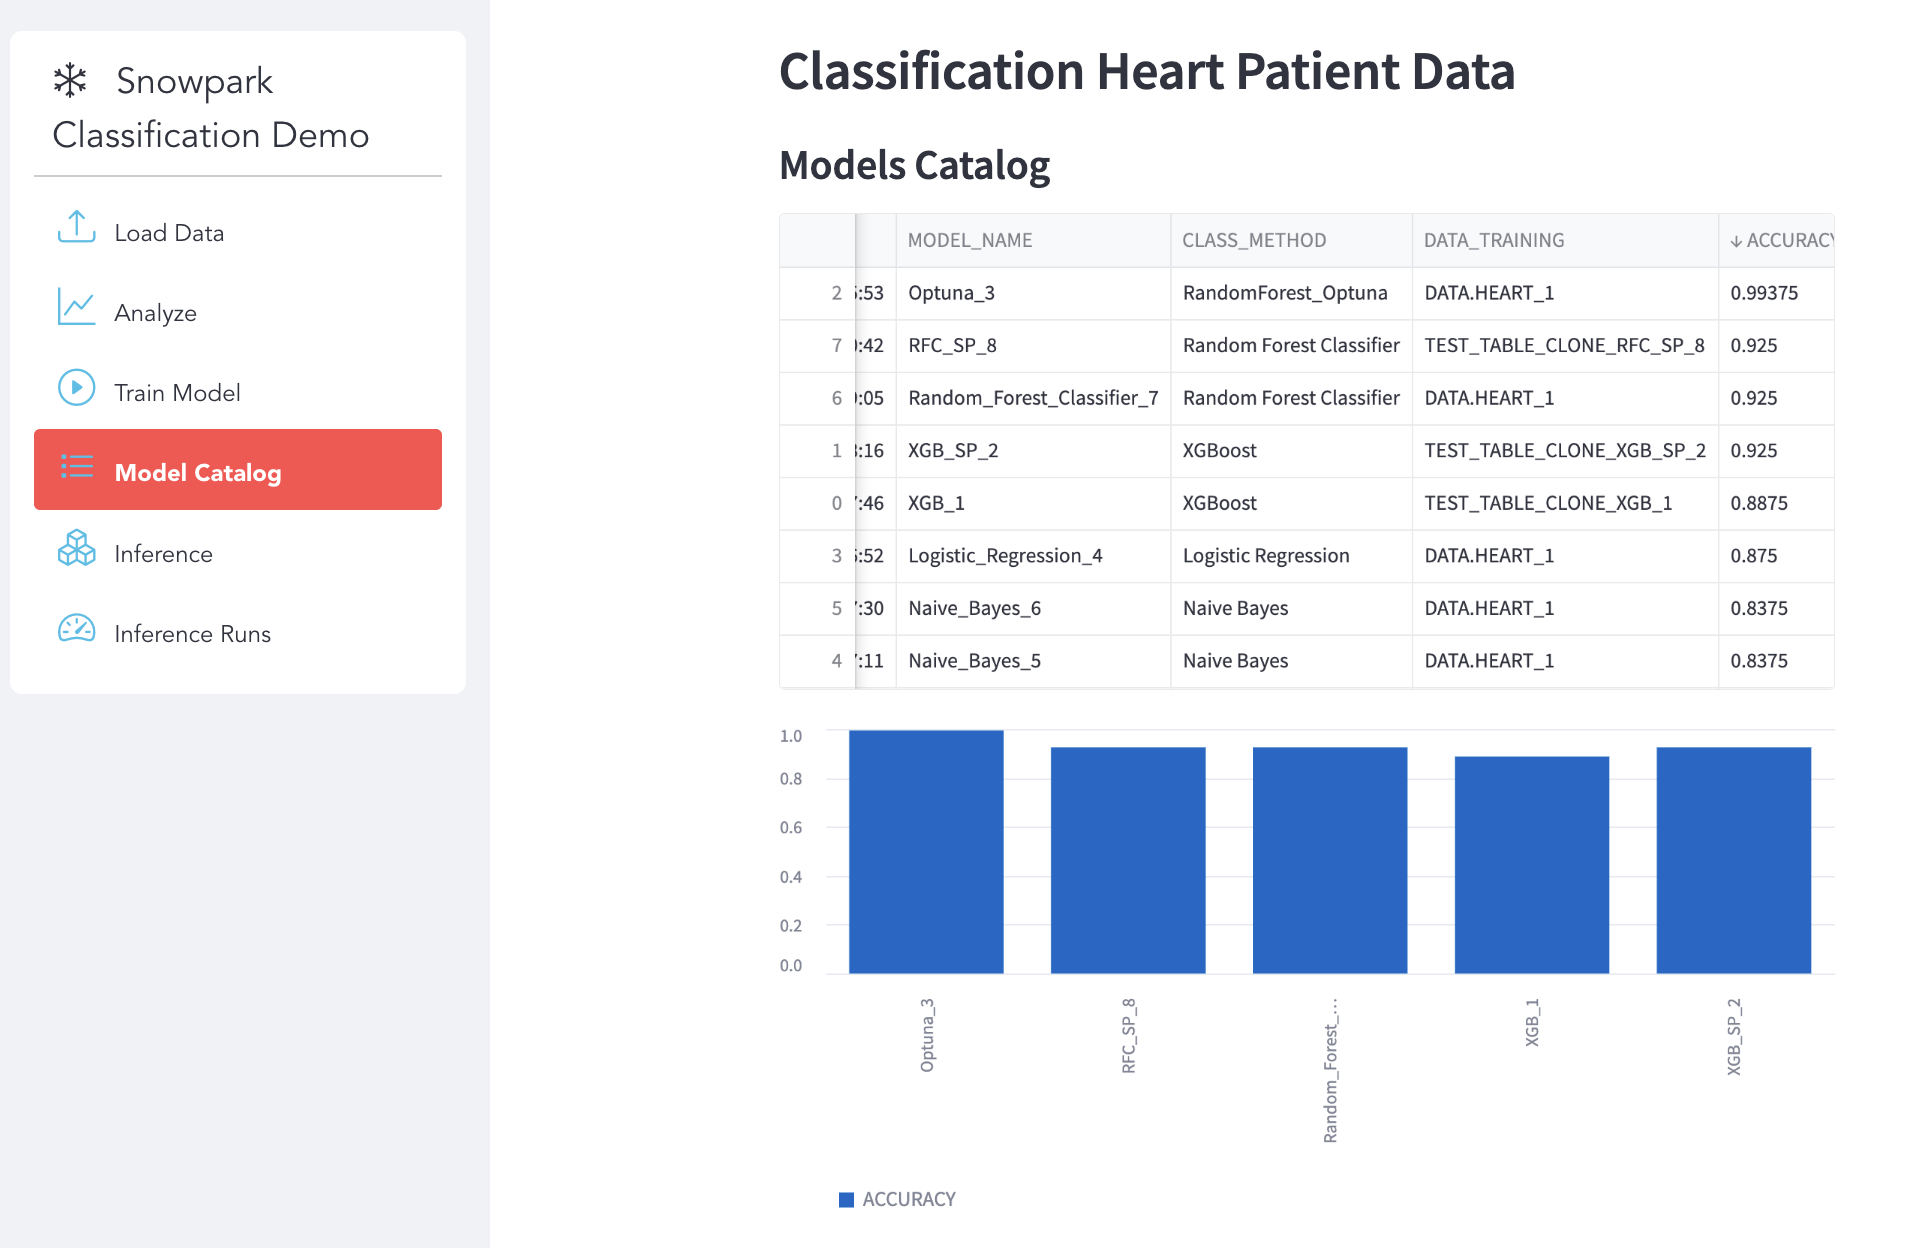

In [47]:
display(Image(filename='images/UI.png', embed=True))